In [1]:
from setup_libs import *

# [CatBoost](https://github.com/catboost/catboost)

Бустинг от Яндекса для категориальных фичей и много чего еще.

Для начала рекомендуется посмотреть видео. Там идет основная теория по CatBoost

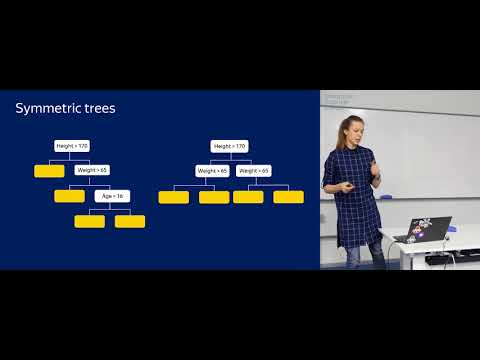

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('UYDwhuyWYSo', width=640, height=360)

# [Примеры](https://catboost.ai/docs/concepts/python-usages-examples.html#custom-objective-function) работы с CatBoost 

Еще одно очень полезное видео, но теперь уже с практикой.

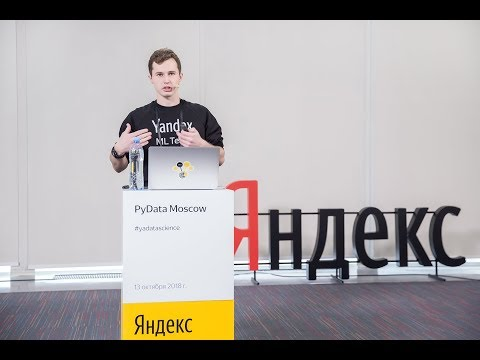

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('xl1fwCza9C8', width=640, height=360)

## Простой пример

In [4]:
from catboost import CatBoostRegressor
from sklearn.datasets import  load_diabetes

In [5]:
train_data = [[1, 4, 5, 6],
              [4, 5, 6, 7],
              [30, 40, 50, 60]]

eval_data = [[2, 4, 6, 8],
             [1, 4, 50, 60]]

train_labels = [10, 20, 30]
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)
# Fit model
model.fit(train_data, train_labels)
# Get predictions
preds = model.predict(eval_data)

0:	learn: 6.1237244	total: 45.8ms	remaining: 45.8ms
1:	learn: 4.5927933	total: 46ms	remaining: 0us


## Визуализация

In [6]:
rng = np.random.RandomState(31337)

boston = load_diabetes()
y = boston['target']
X = boston['data']

kf = KFold(n_splits=3, shuffle=True, random_state=rng)

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.25)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

In [7]:
cb = CatBoostRegressor(silent=True, eval_metric="MAE", custom_metric=["MAPE"])

Тут включена крутая визуализация, с которой можно поиграться, она не работает в Jupyter Lab, но работает в Jupyter Notebook

In [8]:
cb.fit(X_train, y_train, eval_set=[(X_val , y_val ), (X_test, y_test)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Бинаризации float

 Выбрать стратегию бинаризации можно установив параметр *feature_border_type*.
 
  - **Uniform**. Границы выбираются равномерно по значениям;
  - **Median**. В каждый бин попадает примерно одинаковое число различных значений;
  - **UniformAndQuantiles**. Uniform + Median;
  - **MaxLogSum, GreedyLogSum**. Максимизируется значение формулы $\sum_{i=1}^K \log(n_i)$, где $K$ - требуемое кол-во бинов, $n_i$ число объектов в этом бакете;
  - **MinEntropy**. Аналогично, но максимизируется энтропия: $-\sum_{i=1}^K n_i \log(n_i)$

In [9]:
from sklearn.model_selection import GridSearchCV

params = {"feature_border_type": [
    "Uniform",
    "Median",
    "UniformAndQuantiles",
    "MaxLogSum",
    "GreedyLogSum",
    "MinEntropy"
]}

cb = CatBoostRegressor(silent=True)
grid = GridSearchCV(cb, params)
grid.fit(X, y)

for score, strategy in sorted(zip(grid.cv_results_['mean_test_score'],
                                  grid.cv_results_['param_feature_border_type'].data)):
    print("MSE: {}, strategy: {}".format(score, strategy))

MSE: 0.38848614730506464, strategy: Uniform
MSE: 0.3923601845840447, strategy: MinEntropy
MSE: 0.3924752720846779, strategy: MaxLogSum
MSE: 0.3933510104967211, strategy: GreedyLogSum
MSE: 0.39459674180540344, strategy: Median
MSE: 0.3989786502807296, strategy: UniformAndQuantiles


## Feature importance

In [10]:
cb = CatBoostRegressor(silent=True)
cb.fit(X_train, y_train)
for value, name in sorted(zip(cb.get_feature_importance(fstr_type="FeatureImportance"),
                              boston["feature_names"])):
    print("{}\t{}".format(name, value))


sex	4.220807849807068
s4	4.895212514402997
s3	7.523050317777018
s2	7.669489850582025
s1	7.9709124732153676
s6	7.980387421636684
age	8.764856068818636
bp	11.828349347867832
bmi	19.175923121314373
s5	19.97101103457801


# Categorical features

In [11]:
from catboost.datasets import titanic
titanic_df = titanic()

X = titanic_df[0].drop('Survived',axis=1)
y = titanic_df[0].Survived

In [12]:
X.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
is_cat = (X.dtypes != float)
is_cat.to_dict()

{'PassengerId': True,
 'Pclass': True,
 'Name': True,
 'Sex': True,
 'Age': False,
 'SibSp': True,
 'Parch': True,
 'Ticket': True,
 'Fare': False,
 'Cabin': True,
 'Embarked': True}

In [14]:
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]

/tmp/ipykernel_275793/2555478007.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[feature].fillna("NAN", inplace=True)


In [15]:
cat_features_index

array([ 0,  1,  2,  3,  5,  6,  7,  9, 10])

In [16]:
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Аналогом для класса DMatrix в катбусте служит класс **catboost.Pool**. Помимо прочего, содержит индексы категориальных факторов и описание пар для режима попарного обучения.

[Подробнее](https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_pool-docpage/)

In [17]:
from catboost import Pool
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.85, random_state=1234)

train_pool = Pool(data=X_train, 
                  label=y_train, 
                  cat_features=cat_features_index, #  в явном виде передаем категориальные фичи,  которыми хотим работать
                  feature_names=list(X_train.columns)) # названия фич, для удобной визуализации и дебага

test_pool = Pool(data=X_test, 
                 label=y_test, 
                 cat_features=cat_features_index, 
                 feature_names=list(X_test.columns))

In [18]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier(eval_metric='Accuracy', use_best_model=True, random_seed=42)
model.fit(train_pool, eval_set=test_pool, metric_period=100)
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

Learning rate set to 0.029583
0:	learn: 0.8124174	test: 0.8059701	best: 0.8059701 (0)	total: 4.79ms	remaining: 4.78s
100:	learn: 0.8520476	test: 0.8432836	best: 0.8432836 (100)	total: 368ms	remaining: 3.28s
200:	learn: 0.8811096	test: 0.8432836	best: 0.8432836 (100)	total: 710ms	remaining: 2.82s
300:	learn: 0.9009247	test: 0.8432836	best: 0.8432836 (100)	total: 1.02s	remaining: 2.38s
400:	learn: 0.9180978	test: 0.8432836	best: 0.8432836 (100)	total: 1.38s	remaining: 2.06s
500:	learn: 0.9299868	test: 0.8507463	best: 0.8507463 (500)	total: 1.73s	remaining: 1.72s
600:	learn: 0.9326288	test: 0.8432836	best: 0.8507463 (500)	total: 2.08s	remaining: 1.38s
700:	learn: 0.9365918	test: 0.8358209	best: 0.8507463 (500)	total: 2.43s	remaining: 1.04s
800:	learn: 0.9431968	test: 0.8432836	best: 0.8507463 (500)	total: 2.79s	remaining: 693ms
900:	learn: 0.9511229	test: 0.8358209	best: 0.8507463 (500)	total: 3.15s	remaining: 346ms
999:	learn: 0.9564069	test: 0.8208955	best: 0.8507463 (500)	total: 3.5s	r

0.8849252013808975

На самом деле в Catboost происходит еще много чего интересного при обработке категорий:
  - среднее сглаживается некоторым априорным приближением;
  - по факту обучается несколько (3) модели на разных перестановках;
  - рассматриваются композиции категориальных факторов (max_ctr_complexity);
  - в момент применения модели, новые объекты приписываются в конец перестановки по обучающей выборке и, таким образом, статистика для них считается по всем имеющимся данным;
  - таргето-независимые счетчики считаются по всем данным.
  - для факторов с небольшим числом различных значений производится OneHotEncoding (параметр one_hot_max_size - максимальное значение для OneHotEncoding'а)

# [Категориальные статистики](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html)

Одно из основных преимуществ катбуста - обработка категориальных факторов.

Такие факторы заменяются на "счетчики": для каждого значения кат.фактора **по таргету** вычисляется некоторая **статистика** этого значения (счетчик, ctr), например, среднее значение таргета по объектам, которые имеют данное значение категориального фактора. Далее категориальный фактор заменяется на подсчитанные для него статистики (каждое значение фактора на свою статистику).

Будем использовать технику кодирования категориальных признаков средним значением целевого признака.
Основная идея – для каждого значения категориального признака посчитать среднее значение целевого признака и заменить категориальный признак на посчитанные средние. 

Давайте попробуем сделать следующую операцию: 
* Возьмем категориальную фичу (один столбец). Пусть фича принимает $m$ значений: $l_1, \ldots, l_m$
* Заменим значение $l_k$ на $\frac{1}{N_{l_k}}\sum_{i \in l_k}y_i$ - среднее значение целевой переменной для данного значения категориальной фичи.
* Переменной в тесте будут приравниваться все средние значения данных

In [19]:
df_train = pd.DataFrame({'float':[1,2,3,4,5], 
                        'animal': ['cat', 'dog', 'cat', 'dog', 'cat'],
                        'sign': ['rock', 'rock', 'paper', 'paper', 'paper']})
y_train = np.array([0,1,0,1, 0])

df_test = pd.DataFrame({'float':[6,7,8,9], 
                        'animal': ['cat', 'dog', 'cat', 'dog'],
                        'sign': ['rock', 'rock', 'paper', 'paper']})

In [20]:
import warnings
warnings.filterwarnings("ignore")

def mean_target(df_train, y_train, df_test):
    n = len(df_train)
    cat_features = df_train.columns[df_train.dtypes == 'object'].tolist()
    float_features = df_train.columns[df_train.dtypes != 'object'].tolist()
    
    new_X_train = df_train.copy()
    new_X_train['y'] = y_train
    new_X_test = df_test.copy()
    
    
    for col in cat_features:
        mean_dict = new_X_train.groupby(col)['y'].mean().to_dict()
        new_X_train[col + '_mean'] =  df_train[col].map(mean_dict) 
        new_X_test[col + '_mean']  =  df_test[col].map(mean_dict)
    
    return new_X_train, new_X_test

In [21]:
X_train, X_test = mean_target(df_train, y_train, df_test)

In [22]:
X_train

,float,animal,sign,y,animal_mean,sign_mean
0,1,cat,rock,0,0.0,0.500000
1,2,dog,rock,1,1.0,0.500000
2,3,cat,paper,0,0.0,0.333333
3,4,dog,paper,1,1.0,0.333333
4,5,cat,paper,0,0.0,0.333333


In [23]:
X_test

,float,animal,sign,animal_mean,sign_mean
0,6,cat,rock,0.0,0.500000
1,7,dog,rock,1.0,0.500000
2,8,cat,paper,0.0,0.333333
3,9,dog,paper,1.0,0.333333


Данный подход лучше чем One-Hot, так как при нем мы можем серьезно вылететь за пределы памяти.

#### Важный момент. 
В ходе подсчета статистики мы по сути сильно привязываемся к данным. Из-за чего может произойти сильное **переобучение**. 

## Накопительные статистики

Такие манипуляции очень легко могут привести к переобучению, потому что в данные подливается информация о метках объектов, после чего происходит обучение. 

Поэтому в катбусте делают **накопительные статистики**

Особенности работы с категориальными факторами: 
  - объекты перемешиваются в случайном порядке;
  - для i-го объекта и j-го признака в перестановке **статистика** (счетчик) вычисляется по всем объектам, идущим **до него** с таким же значением признака
  - заменяем все категориальные факторы в выборке и обучаем модель
  - Тестовую же выборку просто приравниваем к средним значениям по 

In [24]:
def late_mean_target(df_train, df_test, y_train):
    n = len(df_train)
    cat_features = df_train.columns[df_train.dtypes == 'object'].tolist()
    num_features = df_train.columns[df_train.dtypes != 'object'].tolist()
    
    new_X_test = df_test.copy()
    new_X_train = df_train.copy()
    new_X_train['y'] = y_train
    new_X_train = new_X_train.sample(frac=1).reset_index() #shuffling
    new_X_train['ones'] = np.ones((len(X_train),)) 
    
    for col in cat_features:
        mean_dict = new_X_train.groupby(col)['y'].mean().to_dict()
        new_X_test[col + '_mean']  =  df_test[col].map(mean_dict) / n
        
        count = new_X_train.groupby([col])['ones'].apply(lambda x: x.cumsum()).tolist()
        cumsum = new_X_train.groupby([col])['y'].apply(lambda x: x.cumsum()).tolist()
        new_X_train[col + '_mean'] = (cumsum - new_X_train['y'])/count
        
        
    return new_X_train, new_X_test

In [25]:
df_train = pd.DataFrame({'float':[1,2,3,4,5], 
                        'animal': ['cat', 'dog', 'cat', 'dog', 'cat'],
                        'sign': ['rock', 'rock', 'paper', 'paper', 'paper']})
y_train = np.array([0,1,0,1, 0])

df_test = pd.DataFrame({'float':[6,7,8,9], 
                        'animal': ['cat', 'dog', 'cat', 'dog'],
                        'sign': ['rock', 'rock', 'paper', 'paper']})

In [26]:
X_train, X_test = late_mean_target(df_train, df_test, y_train)

In [27]:
X_train

,index,float,animal,sign,y,ones,animal_mean,sign_mean
0,0,1,cat,rock,0,1.0,0.0,1.000000
1,3,4,dog,paper,1,1.0,-0.5,0.000000
2,4,5,cat,paper,0,1.0,0.0,0.333333
3,2,3,cat,paper,0,1.0,1.0,0.000000
4,1,2,dog,rock,1,1.0,0.5,0.000000


In [28]:
X_test

,float,animal,sign,animal_mean,sign_mean
0,6,cat,rock,0.0,0.100000
1,7,dog,rock,0.2,0.100000
2,8,cat,paper,0.0,0.066667
3,9,dog,paper,0.2,0.066667


## Визуализация

In [29]:
model = CatBoostRegressor(iterations=2, depth=1, boost_from_average=False)

features = [
    [1, 2, 3], 
    [4, 5, 6],
    [7, 8, 9]
]
labels = [1, 0, 1]

model.fit(features, labels, verbose=False);

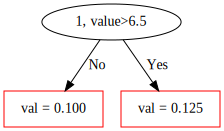

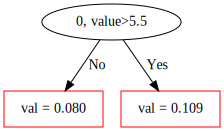

In [30]:
# This cell doesn't work without graphviz package
# You can install it by link https://graphviz.gitlab.io/download/
# Installation can take a lot of time. You can do it at home.

from IPython.display import display

display(model.plot_tree(0))
display(model.plot_tree(1))

In [31]:
x = [0, 7, 2]

raw_pred = model.predict([x])
print(raw_pred)

[0.205]


## Grow Policy

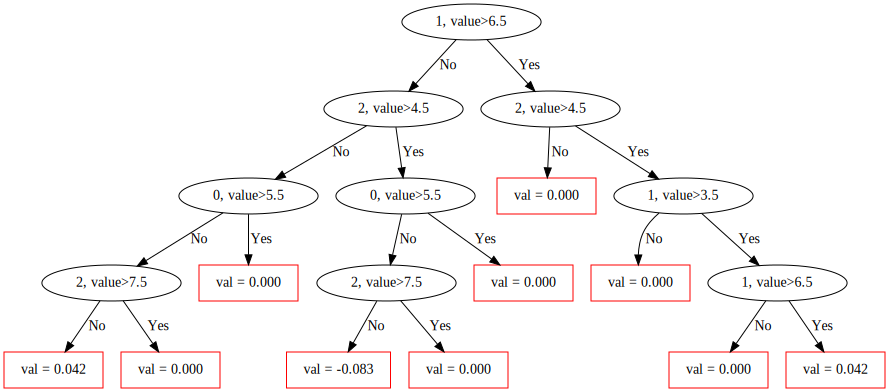

In [32]:
model = CatBoostRegressor(iterations=2, depth=4, grow_policy='Depthwise')
model.fit(features, labels, verbose=False);
display(model.plot_tree(0))

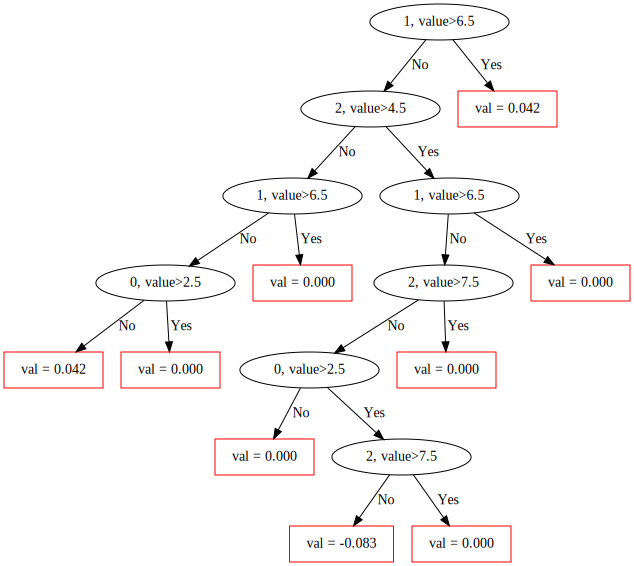

In [33]:
model = CatBoostRegressor(iterations=2, max_leaves=16, grow_policy='Lossguide')
model.fit(features, labels, verbose=False);
display(model.plot_tree(0))

# Полезные ссылки 
* [Tutorial](https://github.com/catboost/tutorials)
* [Github Catboost](https://github.com/catboost/catboost)
* [Статья о Catboost на arxiv](https://arxiv.org/pdf/1706.09516.pdf)
* [Классный семинар про Catboost](https://www.youtube.com/watch?v=ZaP5qFSIcIw)